# Using U-Net Architecture for Fluid Simulation

## Installing Dependencies

In [3]:
%pip install torch --quiet
%pip install torchvision --quiet
%pip install phiflow --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        avg_c = (in_c + out_c) // 2
        
        self.conv1 = nn.Conv2d(in_c, avg_c, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(avg_c)
        
        self.conv2 = nn.Conv2d(avg_c, out_c, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(out_c)
        
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [6]:
class DownSamp(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.conv = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d(2)
        
        
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        
        return x, p

In [7]:
class UpSamp(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_c, out_c, 2, 2)
        self.conv = ConvBlock(out_c+out_c, out_c)
        
        
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        
        return x

In [8]:
class UNet(nn.Module):
    def __init__(self, in_c, out_c, f_size=16):
        super().__init__()
        
        # Downsampling
        self.down1 = DownSamp(in_c, f_size)
        self.down2 = DownSamp(f_size, f_size*2)
        self.down3 = DownSamp(f_size*2, f_size*4)
        self.down4 = DownSamp(f_size*4, f_size*8)
        
        # Bottleneck
        self.b = ConvBlock(f_size * 8, f_size * 16)
        
        # Upsampling
        self.up1 = UpSamp(f_size * 16, f_size*8)
        self.up2 = UpSamp(f_size * 8, f_size*4)
        self.up3 = UpSamp(f_size * 4, f_size*2)
        self.up4 = UpSamp(f_size * 2, f_size)
        
        # Output
        self.output = nn.Conv2d(f_size, out_c, 1, padding='same')
        
    def forward(self, x):
        # Downsampling
        d1, p1 = self.down1(x)
        d2, p2 = self.down2(p1)
        d3, p3 = self.down3(p2)
        d4, p4 = self.down4(p3)
        
        # Bottleneck
        b = self.b(p4)
        
        # Upsampling
        u1 = self.up1(b, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        
        # Output
        output = self.output(u4)
        
        return output

## Pretraining model

In [9]:
def train_random_epoch(size=32, num_batches=1, batch_size=1):
    last_loss = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i in range(num_batches):
        # Every data instance is an input + label pair
        inputs = torch.rand(batch_size, 4, size, size)
        labels = inputs[:, 0:3, :, :]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        last_loss = loss.item()
        print_batch = min(num_batches, max(1,(num_batches // 8)))
        if i == 0 or i % print_batch == print_batch- 1:
            print(i, "batch loss:", last_loss)
        
    return last_loss

In [10]:
model = UNet(4, 3, 8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [11]:
model.train()
print('Size 16:')
train_random_epoch(size=16, num_batches=256, batch_size=32)

Size 16:
0 batch loss: 0.4813016355037689
31 batch loss: 0.24831265211105347
63 batch loss: 0.13877248764038086
95 batch loss: 0.1073465645313263
127 batch loss: 0.084204763174057
159 batch loss: 0.0692233219742775
191 batch loss: 0.05918270722031593
223 batch loss: 0.050822991877794266
255 batch loss: 0.04538210108876228


0.04538210108876228

Difference: 0.1883331835269928
Normalized Difference: 0.18581587076187134


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


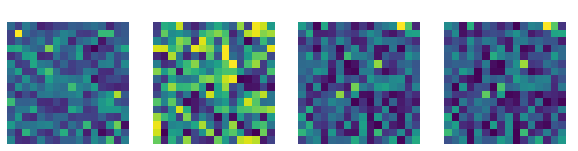

In [12]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

model.eval()
#image is a numpy array
inputs = torch.rand(1, 4, 16, 16)
outputs = model(inputs).detach().numpy()
labels = inputs[:, 0:3, :, :].detach().numpy()
# imshow(inputs[0, 0, :, :])
diff = outputs[0, 0, :, :] - labels[0, 0, :, :]
diff = np.sqrt(diff * diff)

fig = plt.figure(figsize=(10, 7))
rows = 1
cols = 4
# Adds a subplot at the 1st position
fig.add_subplot(rows, cols, 1)
  
# showing image
plt.imshow(outputs[0, 0, :, :])
plt.axis('off')
plt.title("Actual")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, cols, 2)
  
# showing image
plt.imshow(labels[0, 0, :, :])
plt.axis('off')
plt.title("Expected")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, cols, 3)
  
# showing image
plt.imshow(diff)
plt.axis('off')
plt.title("Difference")
print("Difference:", diff.sum() / diff.size)


fig.add_subplot(rows, cols, 4)

normalized = (np.sum(labels[0, 0, :, :])/np.sum(outputs[0, 0, :, :])) * outputs[0, 0, :, :]
diff = normalized - labels[0, 0, :, :]
diff = np.sqrt(diff * diff)
# showing image
plt.imshow(diff)
plt.axis('off')
plt.title("Normalized Difference")
print("Normalized Difference:", diff.sum() / diff.size)

## PhiFlow Things

In [13]:
def stackGrids(den, vel, xMax, yMax, bound = None):
    den = CenteredGrid(den, 0, Box[0:xMax, 0:yMax], x=xMax, y=yMax)
    vel = StaggeredGrid(vel, 0, Box[0:xMax, 0:yMax], x=xMax, y=yMax)
    
    den_val = den.values.numpy(["x","y"])
    vel_x = vel.at_centers().vector['x'].values.numpy(["x","y"])
    vel_y = vel.at_centers().vector['y'].values.numpy(["x","y"])
    if (bound is None):
        x = np.stack((den_val, vel_x, vel_y), axis=0)
    else:
        bound_val = bound.values.numpy(['x', 'y'])
        x = np.stack((den_val, vel_x, vel_y, bound_val), axis=0)
    return torch.tensor([x])

In [14]:
def simulateFlow(den, vel, GRAVITY, DT):
    den = advect.mac_cormack(den, vel, dt=DT)
    gravity_force = den * GRAVITY * DT @ vel
    vel = advect.semi_lagrangian(vel, vel, dt=DT) + gravity_force
    vel, _ = fluid.make_incompressible(vel)
    return den, vel

In [15]:
from phi.flow import *
import numpy as np

def train_one_epoch(model, optimizer, loss_fn, size=32):
    GRAVITY = math.tensor([0, -9.81])
    DT = 1
    xMax = size
    yMax = size
    boundsBox=Box[0:xMax, 0:yMax]
    activeBoundsBox=Box[1:xMax-1, 1:yMax-1]

    den_ref = CenteredGrid(Noise(), extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
    vel_ref = StaggeredGrid(0, extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)

    bound = CenteredGrid(0, extrapolation.ONE, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
    bound = CenteredGrid(bound, x=xMax, y=yMax, bounds=boundsBox)

    den = den_ref
    vel = vel_ref
    
    vel += den * GRAVITY * DT @ vel
    vel, _ = fluid.make_incompressible(vel)
    
    X = stackGrids(den, vel, xMax, yMax, bound)
    
    den, vel = simulateFlow(den, vel, GRAVITY, DT) 
    Y = stackGrids(den, vel, xMax, yMax)
    
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(X)

    # Compute the loss and its gradients
    loss = loss_fn(outputs, Y)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather data and report
    last_loss = loss.item()
    print(size, "batch loss:", last_loss)
        
    return last_loss

In [16]:
model = UNet(4, 3, 8)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

In [17]:
model.train()
size = 64
for i in range(1024):
    train_one_epoch(model, optimizer, loss_fn, size=size)

/var/folders/kb/p338_b2d3q133gnkfsnnxz640000gn/T/ipykernel_13949/1743132527.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  return torch.tensor([x])


64 batch loss: 30.698781967163086
64 batch loss: 25.15546417236328
64 batch loss: 34.83690643310547
64 batch loss: 26.91556739807129
64 batch loss: 25.044565200805664
64 batch loss: 30.473663330078125
64 batch loss: 45.74847412109375
64 batch loss: 24.6363525390625
64 batch loss: 36.170040130615234
64 batch loss: 32.200965881347656
64 batch loss: 29.81162452697754
64 batch loss: 28.897401809692383
64 batch loss: 43.07875061035156
64 batch loss: 26.85651206970215
64 batch loss: 24.63062286376953
64 batch loss: 19.270872116088867
64 batch loss: 18.87598991394043
64 batch loss: 21.505943298339844
64 batch loss: 29.286537170410156
64 batch loss: 25.052988052368164
64 batch loss: 22.927352905273438
64 batch loss: 28.17616081237793
64 batch loss: 23.42439842224121
64 batch loss: 23.45762062072754
64 batch loss: 35.14440155029297
64 batch loss: 18.70587730407715
64 batch loss: 33.53230667114258
64 batch loss: 33.31825637817383
64 batch loss: 18.333858489990234
64 batch loss: 23.50425148010254

KeyboardInterrupt: 

In [ ]:
model = torch.load('models/model_fast.pt')

In [18]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

def test_model(model, size=32, num_frames=1):
    GRAVITY = math.tensor([0, -9.81])
    DT = 1
    xMax = size
    yMax = size
    boundsBox=Box[0:xMax, 0:yMax]
    activeBoundsBox=Box[1:xMax-1, 1:yMax-1]

    den_ref = CenteredGrid(Noise(), extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
    vel_ref = StaggeredGrid(0, extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)

    bound = CenteredGrid(0, extrapolation.ONE, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
    bound = CenteredGrid(bound, x=xMax, y=yMax, bounds=boundsBox)

    den = den_ref
    vel = vel_ref
    
    vel += den * GRAVITY * DT @ vel
    vel, _ = fluid.make_incompressible(vel)
    
    for i in range(num_frames):
        # Create a 2 x 4 plot for the values
        fig = plt.figure(figsize=(10, 7))
        rows = 3
        cols = 4
        
        # Plot Input Density, Velocities, and Barrier
        
        x = stackGrids(den, vel, xMax, yMax, bound)
        den_val = den.values.numpy(["x","y"])
        den_min = den_val.min()
        den_max = den_val.max()
        den_sum = (den_val+den_min).sum()
        print("Density Min", den_min)
        print("Density Max", den_max)
        print("Density Sum", den_sum)
        
        fig.add_subplot(rows, cols, 1)
        plt.imshow(x[0, 0, :, :])
        plt.axis('off')
        plt.title("Input Density")
        
        fig.add_subplot(rows, cols, 2)
        plt.imshow(x[0, 1, :, :])
        plt.axis('off')
        plt.title("Input Vel X")
        
        fig.add_subplot(rows, cols, 3)
        plt.imshow(x[0, 2, :, :])
        plt.axis('off')
        plt.title("Input Vel Y")
        
        fig.add_subplot(rows, cols, 4)
        plt.imshow(x[0, 3, :, :])
        plt.axis('off')
        plt.title("Input Barriers")
        
        # Plot PhiFlow's Output
        
        den, vel = simulateFlow(den, vel, GRAVITY, DT) 
        y = stackGrids(den, vel, xMax, yMax)
        
        fig.add_subplot(rows, cols, 5)
        plt.imshow(y[0, 0, :, :])
        plt.axis('off')
        plt.title("Expected Density")
        
        fig.add_subplot(rows, cols, 6)
        plt.imshow(y[0, 1, :, :])
        plt.axis('off')
        plt.title("Expected Vel X")
        
        fig.add_subplot(rows, cols, 7)
        plt.imshow(y[0, 2, :, :])
        plt.axis('off')
        plt.title("Expected Vel Y")
        
        # Plot Model's Output
        
        outputs = model(x).detach().numpy()
        
        fig.add_subplot(rows, cols, 9)
        plt.imshow(outputs[0, 0, :, :])
        plt.axis('off')
        plt.title("Model's Density")
        
        fig.add_subplot(rows, cols, 10)
        plt.imshow(outputs[0, 1, :, :])
        plt.axis('off')
        plt.title("Model's Vel X")
        fig.add_subplot(rows, cols, 11)
        plt.imshow(outputs[0, 2, :, :])
        plt.axis('off')
        plt.title("Model's Vel Y")

Density Min -3.2984116
Density Max 2.3159218
Density Sum -12679.094
Density Min -3.2984116
Density Max 2.1482244
Density Sum -12624.691
Density Min -3.2984116
Density Max 2.1482244
Density Sum -12478.9795
Density Min -3.0971868
Density Max 2.1482244
Density Sum -11642.936


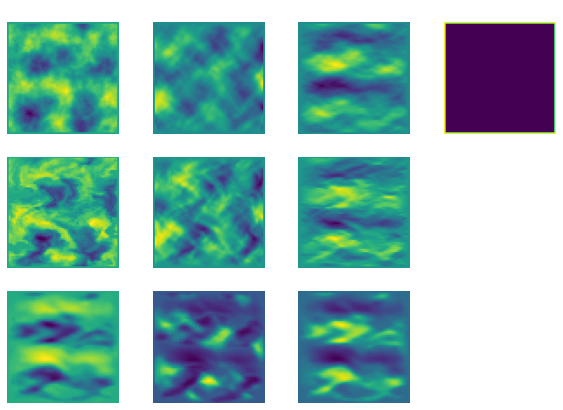

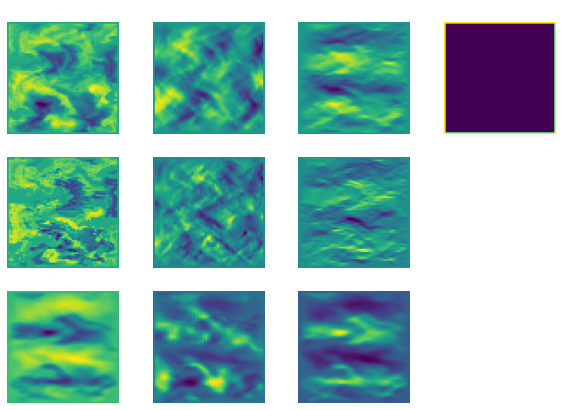

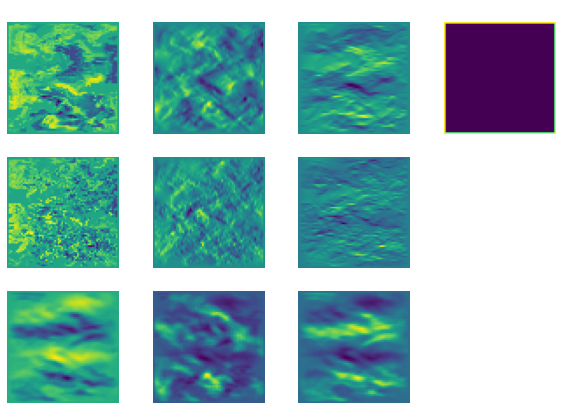

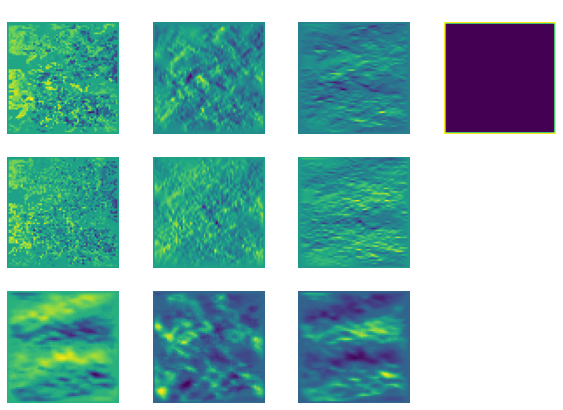

In [20]:
model.eval()
test_model(model, 64, 4)

## Attempting to Animate

TO DO

In [434]:
import numpy as np  
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter  
%matplotlib inline

In [474]:
def clean_output(X, in_den_sum, boundary):
    out_den = X[0,0]
    # out_den = out_den - out_den.min()
    out_den[boundary==1] = 0
    # out_den_sum = out_den.sum()
    # return (in_den_sum/out_den_sum) * out_den
    return out_den

In [1]:
size = 64
GRAVITY = math.tensor([0, -9.81])
DT = 1
xMax = size
yMax = size
boundsBox=Box[0:xMax, 0:yMax]
activeBoundsBox=Box[1:xMax-1, 1:yMax-1]

den_ref = CenteredGrid(Noise(), extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
vel_ref = StaggeredGrid(0, extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)

bound = CenteredGrid(0, extrapolation.ONE, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
bound = CenteredGrid(bound, x=xMax, y=yMax, bounds=boundsBox)

den = den_ref
vel = vel_ref

vel += den * GRAVITY * DT @ vel
vel, _ = fluid.make_incompressible(vel)

x = stackGrids(den, vel, xMax, yMax, bound)
den, vel = simulateFlow(den, vel, GRAVITY, DT) 
y = stackGrids(den, vel, xMax, yMax)

bound_val = bound.values.numpy(['x', 'y'])

den_sum = np.sum(den_ref.values.numpy(["x","y"]))

def update():
    global x
    y = model(x).detach().numpy()
    x = torch.tensor(np.expand_dims(np.stack((y[0, 0], y[0, 1], (y[0, 2]), bound_val), axis=0), 0))
    x[0,0] = clean_output(x, den_sum, bound_val)
    return y

NameError: name 'math' is not defined

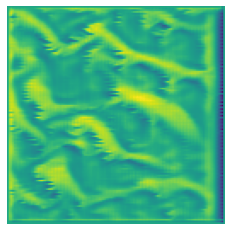

In [476]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.animation as animation 

fig = plt.figure() 

ims = []
for i in range(10):
    plt.axis('off')
    im = plt.imshow(update()[0][0])
    ims.append([im])

In [477]:
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save('water_sim_128_1.mp4')